In [57]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import time


#-----------------------------------------------------------
# 1. Create the initial system configuration.
#-----------------------------------------------------------
@njit
def polymergenerator(polymerl, headl):
    # Center-of-mass (COM)
    COM = np.array([5.0, 2.5, 0.60])
    # Create a linear polymer: each row is a 3D coordinate (x, y, z)
    polymer = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymer[i, 0] = float(i)
        polymer[i, 1] = 0.0
        polymer[i, 2] = 0.0

    # Create polymer surface as 13 copies of the polymer,
    # each shifted in the y-z plane by an offset on a circle (radius 0.5)
    num_copies = 13
    polymersurface = np.empty((polymerl * num_copies, 3))
    for k in range(num_copies):
        angle = 2.0 * np.pi * k / num_copies
        # Compute the offset for this copy (circle in y-z plane)
        offset0 = 0.0
        offset1 = 0.5 * np.cos(angle)
        offset2 = 0.5 * np.sin(angle)
        for i in range(polymerl):
            polymersurface[k * polymerl + i, 0] = polymer[i, 0] + offset0
            polymersurface[k * polymerl + i, 1] = polymer[i, 1] + offset1
            polymersurface[k * polymerl + i, 2] = polymer[i, 2] + offset2

    # Create head surface (4 atoms) as COM plus predefined offsets
    offsets = np.array([[0.1, 0.0, 0.0],
                        [0.0, 0.1, 0.0],
                        [-0.1, 0.0, 0.0],
                        [0.0, -0.1, 0.0]])
    headsurface = COM + offsets
    return polymer, polymersurface, COM, headsurface


#-----------------------------------------------------------
# 2. Force calculation functions.
#-----------------------------------------------------------
@njit
def lj_brownian(a, b, epsilon=0.1, sigma=2.0):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0 * dif0 + dif1 * dif1 + dif2 * dif2)
        if dist > 0:
            f_val = 24 * epsilon * (-2 * (sigma ** 12 / (dist ** 13)) + (sigma ** 6 / (dist ** 7)))
            inv_dist = 1.0 / dist
            f_total[0] += f_val * dif0 * inv_dist
            f_total[1] += f_val * dif1 * inv_dist
            f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit
def lj_repulsive(a, b, epsilon=0.1, sigma=0.5):
    f_total = np.zeros(3)
    for i in range(a.shape[0]):
        dif0 = a[i, 0] - b[0]
        dif1 = a[i, 1] - b[1]
        dif2 = a[i, 2] - b[2]
        dist = np.sqrt(dif0 * dif0 + dif1 * dif1 + dif2 * dif2)
        if dist > 0:
            f_val = 24 * epsilon * (-2 * (sigma ** 12 / (dist ** 13)))
            inv_dist = 1.0 / dist
            f_total[0] += f_val * dif0 * inv_dist
            f_total[1] += f_val * dif1 * inv_dist
            f_total[2] += f_val * dif2 * inv_dist
    return f_total


@njit
def harmonic_angle(surface, COM, n, theta=np.pi / 2, K=2.0):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        j = (i + n) % N
        # Compute vectors from COM to surface atoms
        ab0 = surface[i, 0] - COM[0]
        ab1 = surface[i, 1] - COM[1]
        ab2 = surface[i, 2] - COM[2]
        bc0 = surface[j, 0] - COM[0]
        bc1 = surface[j, 1] - COM[1]
        bc2 = surface[j, 2] - COM[2]
        ab_norm = np.sqrt(ab0 * ab0 + ab1 * ab1 + ab2 * ab2)
        bc_norm = np.sqrt(bc0 * bc0 + bc1 * bc1 + bc2 * bc2)
        if ab_norm == 0.0 or bc_norm == 0.0:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
            continue
        cos_angle = (ab0 * bc0 + ab1 * bc1 + ab2 * bc2) / (ab_norm * bc_norm)
        if cos_angle > 1.0:
            cos_angle = 1.0
        elif cos_angle < -1.0:
            cos_angle = -1.0
        angle_diff = theta - np.arccos(cos_angle)
        # Compute cross products for the double cross product force
        cross_inner0 = bc1 * ab2 - bc2 * ab1
        cross_inner1 = bc2 * ab0 - bc0 * ab2
        cross_inner2 = bc0 * ab1 - bc1 * ab0
        vec0 = ab1 * cross_inner2 - ab2 * cross_inner1
        vec1 = ab2 * cross_inner0 - ab0 * cross_inner2
        vec2 = ab0 * cross_inner1 - ab1 * cross_inner0
        vec_norm = np.sqrt(vec0 * vec0 + vec1 * vec1 + vec2 * vec2)
        if vec_norm != 0.0:
            factor = -2 * K * angle_diff / vec_norm
            force[i, 0] = factor * vec0
            force[i, 1] = factor * vec1
            force[i, 2] = factor * vec2
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


@njit
def harmonic_surface(surface, COM, epsilon=10, sigma=0.1):
    N = surface.shape[0]
    force = np.empty((N, 3))
    for i in range(N):
        dx = surface[i, 0] - COM[0]
        dy = surface[i, 1] - COM[1]
        dz = surface[i, 2] - COM[2]
        norm_val = np.sqrt(dx * dx + dy * dy + dz * dz)
        if norm_val > 0:
            factor = 2 * epsilon * (sigma - norm_val) / norm_val
            force[i, 0] = factor * dx
            force[i, 1] = factor * dy
            force[i, 2] = factor * dz
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
            force[i, 2] = 0.0
    return force


#-----------------------------------------------------------
# 3. Define the integration function (Not-Verlet algorithm)
#-----------------------------------------------------------
@njit
def notverlet(COM, surface, dt, random_val, mu, polymer, polymersurface):
    # Compute harmonic angle forces and sum them
    N = surface.shape[0]
    force1 = harmonic_angle(surface, COM, 1)
    force2 = harmonic_angle(surface, COM, -1)
    force3 = harmonic_angle(surface, COM, 2, np.pi)
    angle_forces = force1 + force2 + force3

    # Compute harmonic bond force
    harmonic_bond = harmonic_surface(surface, COM)

    # Compute Lennard-Jones (Brownian) force on a particular surface atom (index 3)
    lj_force_surf = np.zeros_like(surface)
    lj_force_surf[3] = lj_brownian(polymersurface, surface[3], 100, 0.02)

    # Update surface positions
    new_surface = np.empty_like(surface)
    for i in range(surface.shape[0]):
        for j in range(3):
            new_surface[i, j] = surface[i, j] + dt * (
                        mu * (angle_forces[i, j] + harmonic_bond[i, j] + lj_force_surf[i, j]) + np.random.uniform(-random_val, random_val) )

    # Compute repulsive force on COM from polymer
    lj_force_COM = lj_repulsive(polymer, COM, 0.01, 0.4)

    # Sum harmonic bond forces over surface atoms (exclude angle forces per corrected dynamics)
    harmonic_sum = np.zeros(3)
    for i in range(harmonic_bond.shape[0]):
        harmonic_sum[0] += harmonic_bond[i, 0]
        harmonic_sum[1] += harmonic_bond[i, 1]
        harmonic_sum[2] += harmonic_bond[i, 2]

    # Update COM position
    new_COM = np.empty(3)
    for j in range(3):
        new_COM[j] = COM[j] + dt * (mu * (lj_force_COM[j] - harmonic_sum[j]) + np.random.uniform(-random_val, random_val))
    return new_COM, new_surface


#-----------------------------------------------------------
# 4. Define the simulation loop.
#    Progress messages are printed every 'print_every' steps.
#-----------------------------------------------------------
@njit
def simulate(COM, surface, polymer, polymersurface, steps, dt, random_val, mu, print_every, hist_every=10000):
    headhist = np.empty((steps, 3))
    surfacehist = np.empty((steps, surface.shape[0], 3))
    headhist[0] = COM
    surfacehist[0] = surface
    for i in range(0, steps+1):
        COM, surface = notverlet(COM, surface, dt, random_val, mu, polymer, polymersurface)
        if i % hist_every == 0:
            headhist[i] = COM
            surfacehist[i] = surface
        if i % print_every == 0:
            print("Step", i, "/", steps, "COM:", COM[0], COM[1], COM[2])
    return headhist, surfacehist


In [58]:

#-----------------------------------------------------------
# 5. Main simulation parameters and execution.
#-----------------------------------------------------------
polymerLength = 10
headN = 1
steps = 10000000
dt = 0.01
random_val = 0.1
mu = 1.0
print_every = 1000000

# Initialize the system.
polymer, polymersurface, COM, surface = polymergenerator(polymerLength, headN)

# Run the simulation (the entire simulation loop is compiled for speed).
start = time.perf_counter()
headhist, surfacehist = simulate(COM, surface, polymer, polymersurface, steps, dt, random_val, mu, print_every)
print("Simulation complete. Final COM:", headhist[-1])
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

Step 0 / 10000000 COM: 4.999847547524035 2.5007629780851546 0.5993012865073605
Step 1000000 / 10000000 COM: 5.760900744304661 2.0514331406095025 0.2656611869668244
Step 2000000 / 10000000 COM: 7.006126621843341 1.1260979222800498 0.05153399042655814
Step 3000000 / 10000000 COM: 6.908504871990628 1.1240166206127806 0.5276691067232486
Step 4000000 / 10000000 COM: 6.652920869168504 1.0122152903327213 0.3816033622646799
Step 5000000 / 10000000 COM: 6.653033072604947 1.1005896376273587 0.7455521848454187
Step 6000000 / 10000000 COM: 6.882476200365463 0.6737662060716918 1.2022285510163322
Step 7000000 / 10000000 COM: 6.872012225379626 0.9707899264848548 1.8065577410187306
Step 8000000 / 10000000 COM: 6.531072998888547 1.349163409248783 2.0842927640121385
Step 9000000 / 10000000 COM: 6.849902770472211 1.3788270651369543 2.4244530787035203
Step 10000000 / 10000000 COM: 7.003909311148147 1.746497514601379 2.9653988326295946
Simulation complete. Final COM: [0. 0. 0.]
Elapsed (after compilation) 

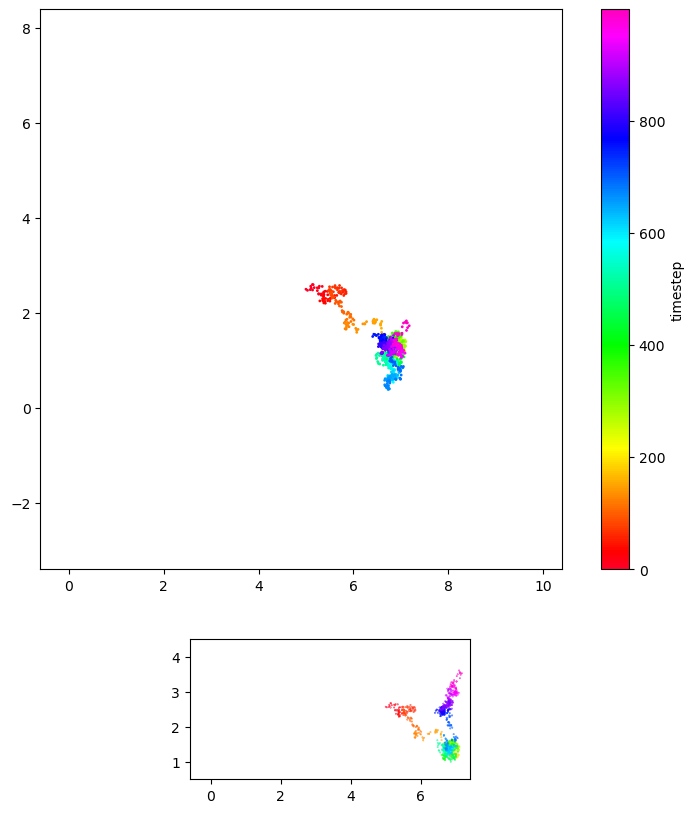

In [59]:
# (This cell uses your original plotting tools.)
render_everyN = 10000
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3], axis=1)
time_arr = np.arange(steps/render_everyN)



#fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 4]}, figsize=(10, 10))
fig, ax = plt.subplots(2,gridspec_kw={'height_ratios': [4, 1], "width_ratios": [1]}, figsize=(10,10))
pos = ax[0].scatter(headhist[::render_everyN, 0], headhist[::render_everyN, 1], cmap="gist_rainbow", c=time_arr, s=1)
ax[0].set_xlim(-0.6, 10.4)
ax[0].set_ylim(-3.4, 8.4)
ax[0].set_aspect("equal", adjustable="box")
perp = ax[1].scatter(headhist[::render_everyN, 0], orthogonal_distance[::], cmap="gist_rainbow", c=time_arr, s=0.1)
ax[1].set_xlim(-0.6, 7.4)
ax[1].set_ylim(0.5, 4.5)
ax[1].set_aspect("equal", adjustable="box")
fig.colorbar(pos, label='timestep')
plt.show()

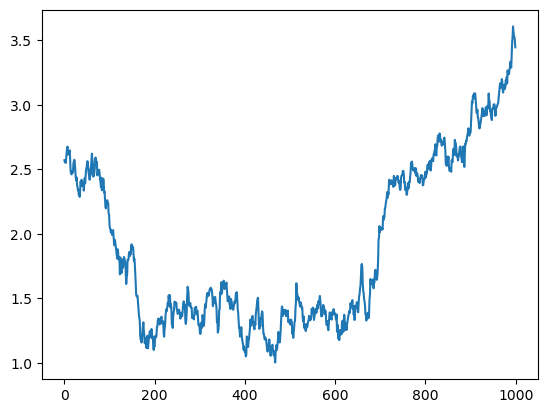

In [60]:
plt.plot(time_arr, orthogonal_distance)

In [50]:
with open("trajectoryn.xyz", "w") as f:
    for t, positions in enumerate(np.concatenate(((np.reshape(headhist[::10000],(1000,1,3))), surfacehist[::10000]),axis=1)):
        f.write(f"5 \n \n")
        f.write(f"C1 {positions[0,0]:8.3f}{positions[0,1]:8.3f}{positions[0,2]:8.3f} \n")
        f.write(f"C2 {positions[1,0]:8.3f}{positions[1,1]:8.3f}{positions[1,2]:8.3f} \n")
        f.write(f"C3 {positions[2,0]:8.3f}{positions[2,1]:8.3f}{positions[2,2]:8.3f} \n")
        f.write(f"C4 {positions[3,0]:8.3f}{positions[3,1]:8.3f}{positions[3,2]:8.3f} \n")
        f.write(f"C5 {positions[4,0]:8.3f}{positions[4,1]:8.3f}{positions[4,2]:8.3f} \n")

In [51]:
with open("polymerrn.xyz", "w") as f:
    f.write(f"130 \n \n")
    for i in range(polymerLength*13):
        f.write(f"C{i+6} {polymersurface[i,0]:8.3f}{polymersurface[i,1]:8.3f}{polymersurface[i,2]:8.3f} \n")

In [37]:
    np.linalg.norm(surfacehist[-1]-headhist[-1], axis=1)

array([0.49131413, 0.58846243, 0.57111075, 0.51252521])

In [40]:
def harmonic_angle1(surface, COM, n, theta=np.pi/2, K=2.0, random=0.1):
    ab = surface - COM
    bc = np.roll(surface, n, axis=0) - COM
    ab_norm = np.linalg.norm(ab, axis=1)   # shape: (N-1,)
    bc_norm = np.linalg.norm(bc, axis=1)   # shape: (N-1,)
    cos_angle = np.sum(ab * bc, axis=1) / (ab_norm * bc_norm)
    cos_angle = np.clip(cos_angle, -1, 1)
    angle_diff = theta - np.arccos(cos_angle)   # shape: (N-1,)
    cross_inner = np.cross(bc, ab)   # shape: (N-1, 3)
    vector = np.cross(ab, cross_inner)  # shape: (N-1, 3)
    vec_norm = np.linalg.norm(vector, axis=1)  # shape: (N-1,)
    with np.errstate(divide='ignore', invalid='ignore'):
        force = -2 * K * angle_diff[:, np.newaxis] * vector / vec_norm[:, np.newaxis]
        force[vec_norm == 0] = 0
    return force

In [219]:
surfacetest = surface.copy() + np.random.uniform(-0.01,0.01, (4,3))
surfacetest


array([[5.1064425 , 2.49128298, 0.5940964 ],
       [5.00095253, 2.60307885, 0.60841869],
       [4.89713886, 2.5065046 , 0.5930806 ],
       [4.99032083, 2.39984635, 0.5996057 ]])

In [53]:
def harmonic_surface1(surface, COM, epsilon=1, sigma=0.1, random=0.1):
    ab = surface - COM
    ab_norm = np.linalg.norm(ab, axis=1)
    force = 2*epsilon*(sigma-ab_norm)[:,np.newaxis]*ab/ab_norm[:, np.newaxis]
    return force

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
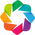

:Layout
   .DynamicMap.I  :DynamicMap   []
      :RGB   [x,y]   (R,G,B,A)
   .DynamicMap.II :DynamicMap   []
      :RGB   [x,y]   (R,G,B,A)

In [15]:
import holoviews as hv
import datashader as ds
import holoviews.operation.datashader as hd
import pandas as pd
import numpy as np

hv.extension('bokeh')

# Use the same subsampling as before
render_everyN = 200
# Create a time array for the rendered points
rendered_time = np.arange(steps)[::render_everyN]

# Prepare DataFrames for the two plots.
# Plot 1: Scatter of COM x vs. COM y
df1 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': headhist[::render_everyN, 1],
    'time': headhist[::render_everyN, 0] * 0.0 + rendered_time  # associate time (or use headhist if desired)
})

# Plot 2: Scatter of COM x vs. orthogonal distance
orthogonal_distance = np.linalg.norm(headhist[::render_everyN, 1:3], axis=1)
df2 = pd.DataFrame({
    'x': headhist[::render_everyN, 0],
    'y': orthogonal_distance,
    'time': rendered_time
})

# Create Holoviews Points objects.
points1 = hv.Points(df1, kdims=['x', 'y'], vdims=['time'])
points2 = hv.Points(df2, kdims=['x', 'y'], vdims=['time'])

# Apply Datashader to each plot for interactive aggregation.
shaded1 = hd.datashade(points1, cmap="gist_rainbow", aggregator=ds.mean('time'))
shaded2 = hd.datashade(points2, cmap="gist_rainbow", aggregator=ds.mean('time'))

# Set options (titles, colorbars, dimensions, etc.)
shaded1 = shaded1.opts(title="COM Trajectory (x vs. y)",
                       frame_width=600, frame_height=400, bgcolor='black')
shaded2 = shaded2.opts(title="COM Trajectory (x vs. Orthogonal Distance)",
                       frame_width=600, frame_height=200)

# Layout the two plots vertically.
layout = hv.Layout([shaded1, shaded2]).cols(1)
layout

In [41]:
@njit
def polymergenerator1(polymerl):
    # Center-of-mass (COM)
    COM = np.array([5.0, 2.5, 0.60])
    # Create a linear polymer: each row is a 3D coordinate (x, y, z)
    polymer = np.empty((polymerl, 3))
    for i in range(polymerl):
        polymer[i, 0] = float(i)
        polymer[i, 1] = 0.0
        polymer[i, 2] = 0.0

    # Create polymer surface as 13 copies of the polymer,
    # each shifted in the y-z plane by an offset on a circle (radius 0.5)
    num_copies = 13
    polymersurface = np.empty((polymerl * num_copies, 3))
    for k in range(num_copies):
        angle = 2.0 * np.pi * k / num_copies
        # Compute the offset for this copy (circle in y-z plane)
        offset0 = 0.0
        offset1 = 0.5 * np.cos(angle)
        offset2 = 0.5 * np.sin(angle)
        for i in range(polymerl):
            polymersurface[k * polymerl + i, 0] = polymer[i, 0] + offset0
            polymersurface[k * polymerl + i, 1] = polymer[i, 1] + offset1
            polymersurface[k * polymerl + i, 2] = polymer[i, 2] + offset2

    # Create head surface (4 atoms) as COM plus predefined offsets
    offsets = np.array([[0.1, 0.0, 0.0],
                        [0.0, 0.1, 0.0],
                        [-0.1, 0.0, 0.0],
                        [0.0, -0.1, 0.0]])
    headsurface = COM + offsets
    return polymer, polymersurface, COM, headsurface

asadf, polymersurface1, saf, fsadfgs = polymergenerator1(10)
polymersurface

array([[ 0.        ,  0.5       ,  0.        ],
       [ 1.        ,  0.5       ,  0.        ],
       [ 2.        ,  0.5       ,  0.        ],
       [ 3.        ,  0.5       ,  0.        ],
       [ 4.        ,  0.5       ,  0.        ],
       [ 5.        ,  0.5       ,  0.        ],
       [ 6.        ,  0.5       ,  0.        ],
       [ 7.        ,  0.5       ,  0.        ],
       [ 8.        ,  0.5       ,  0.        ],
       [ 9.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.44272801,  0.23236159],
       [ 1.        ,  0.44272801,  0.23236159],
       [ 2.        ,  0.44272801,  0.23236159],
       [ 3.        ,  0.44272801,  0.23236159],
       [ 4.        ,  0.44272801,  0.23236159],
       [ 5.        ,  0.44272801,  0.23236159],
       [ 6.        ,  0.44272801,  0.23236159],
       [ 7.        ,  0.44272801,  0.23236159],
       [ 8.        ,  0.44272801,  0.23236159],
       [ 9.        ,  0.44272801,  0.23236159],
       [ 0.        ,  0.28403237,  0.411